In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

## Part 0: Generate datasets

In [2]:
def create_agaricus_lepiota_dataset(path='dataset'):
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    headers = ['Class', 'CapShape',
          'CapSurface', 'CapColor',
          'Bruises', 'Odor',
          'GillAttachment','GillSpacing',
          'GillSize','GillColor',
          'StalkShape', 'StalkRoot',
          'StalkAboveRing', 'StalkBelowRing',
          'ColorAboveRing', 'ColorBelowRing',
          'VeilType', 'VeilColor',
          'RingNumber', 'RingType',
          'SporeColor','Population',
          'Habitat']

    dataset_raw = pd.read_csv(url, header = None, names = headers).dropna(axis=1)
    dataset_raw = dataset_raw.apply(LabelEncoder().fit_transform)
    dataset_raw["Class"].replace(0, -1, inplace=True)
    X = dataset_raw.iloc[:,1:].to_numpy()
    y = dataset_raw.iloc[:,0].to_numpy()
    return X, y

In [3]:
def create_chess_dataset(n_samples = 1000, scale = 5):
    np.random.seed(0)
    X = np.random.uniform(low=0, high=1, size=(n_samples, 2))
    y = (np.sin(np.pi * X[:, 0] * scale) > 0) ^ (np.sin(np.pi * X[:, 1] * scale) > 0)
    y = np.where(y,1,-1)
    X -= 0.5
    X *=40
    return X ,y 

In [4]:
def create_2d_dataset(n_samples=1000, scale = 20, noise = 3):
    np.random.seed(0)
    X = np.random.rand(n_samples, 2) * scale - scale/2
    y = (X[:,0]>X[:, 1]).astype(int) 
    if noise > 0:
        X = X + np.random.normal(0,noise,size=X.shape)
    y[y==0] = -1
    return X, y

In [5]:
def reduce_dimension(X_train, X_test):
    tsne = TSNE(n_components=2, perplexity=30)
    tsne_X_train = tsne.fit_transform(X_train)
    nn = NearestNeighbors(n_neighbors=4)
    nn.fit(X_train)
    train_neighbors = nn.kneighbors(np.squeeze(X_test), 3 , return_distance=False)
    tsne_X_test = tsne_X_train[train_neighbors].mean(axis=1)
    return tsne_X_train, tsne_X_test

In [6]:
X1, y1 = create_agaricus_lepiota_dataset()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state=42, shuffle=True)
X_train1_reduced, X_test1_reduced = reduce_dimension(X_train1, X_test1)
X2, y2 = create_chess_dataset()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42, shuffle=True)
X3, y3 = create_2d_dataset()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.20, random_state=42, shuffle=True)

In [7]:
class Database():
    def __init__(self, name, X_train, X_test, y_train, y_test, X_train_reduced = None, X_test_reduced = None):
        self.name = name
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_train_reduced = X_train_reduced
        self.X_test_reduced = X_test_reduced
        self.n_samples = X_train.shape[0] + X_test.shape[0]
        self.n_features = X_train.shape[1]


In [8]:
AgaricusL_db = Database("Agaricus-Lepiota", X_train1, X_test1, y_train1, y_test1, X_train1_reduced, X_test1_reduced)
chess_db = Database("Chess", X_train2, X_test2, y_train2, y_test2)
twoD_db = Database("2D", X_train3, X_test3, y_train3, y_test3)
datasets = [AgaricusL_db, chess_db, twoD_db]

In [9]:
for dataset in datasets:
    print(f'{dataset.name} Dataset: -- {dataset.n_samples} samples and {dataset.n_features} features')

Agaricus-Lepiota Dataset: -- 8124 samples and 22 features
Chess Dataset: -- 1000 samples and 2 features
2D Dataset: -- 1000 samples and 2 features


<Figure size 800x800 with 0 Axes>

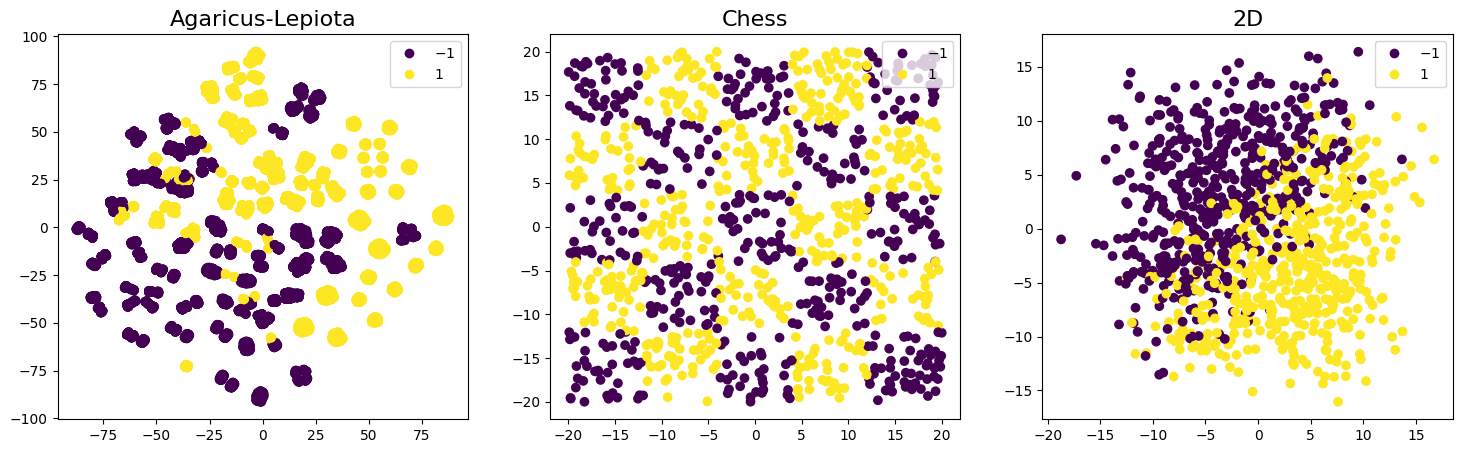

In [10]:
plt.figure(figsize=(8, 8))
fig, axes = plt.subplots(1,3, figsize=(18, 5))
for i, dataset in enumerate(datasets):
    X_train = dataset.X_train
    X_test = dataset.X_test
    if dataset.name == "Agaricus-Lepiota":
     X_train = dataset.X_train_reduced
     X_test = dataset.X_test_reduced
    scatter = axes[i].scatter(X_train[:,0], X_train[:,1], c=dataset.y_train, label=dataset.y_train)
    scatter = axes[i].scatter(X_test[:,0], X_test[:,1], c=dataset.y_test, label=dataset.y_test)
    axes[i].set_title(dataset.name, size=16)
    axes[i].legend(*scatter.legend_elements(), loc='upper right')

## Part 1: Gradient Boosting Regression Trees (GBRT)

In [11]:
class GBRT:
    def __init__(self, alpha: float = 0.1, max_depth: int = 4, n_trees: int = 100) -> None:
        self.alpha = alpha
        self.max_depth = max_depth
        self.n_trees = n_trees
        self.trees = []
        self.train_errors = np.zeros(n_trees)
        self.test_errors = np.zeros(n_trees)

    def calc_loss(self, y: np.array, y_pred: np.array):
        return np.square(y_pred-y).mean()
    
    def fit(self, X: np.array, y: np.array, X_test:np.array, y_test:np.array) -> list:
        loss_history = []
        test_loss = []
        pred = np.zeros(y.shape)
        test_pred = np.zeros(y_test.shape)
        for i in range(self.n_trees):
            residuals = y - pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X,residuals)
            y_pred = tree.predict(X)
            pred += self.alpha * y_pred
            self.trees.append(tree)
            loss_history.append(self.calc_loss(y, pred))
            train_error = (y != np.where(pred>=0, 1, -1))
            self.train_errors[i] = train_error.mean()
            y_test_pred = tree.predict(X_test)
            test_pred += self.alpha * y_test_pred
            test_loss.append(self.calc_loss(y_test, test_pred))
            test_error = (y_test != np.where(test_pred>=0, 1, -1))
            self.test_errors[i] = test_error.mean()
        return loss_history , test_loss
    
    def predict(self, X) -> np.array:
         y_pred = np.array(list(map(lambda x: x.predict(X), self.trees))).sum(axis=0) * self.alpha
         return np.where(y_pred>=0, 1, -1)

    def calc_accuracy(self, y, y_pred):
        return 100 * accuracy_score(y, y_pred)   
        



### GBRT - Results

In [12]:
from collections import defaultdict
gbrt_results = defaultdict(lambda: defaultdict(tuple))
models = {}
for dataset in datasets:
    gbrt_model = GBRT(n_trees=100)
    gbrt_train_loss, gbrt_test_loss = gbrt_model.fit(dataset.X_train, dataset.y_train, dataset.X_test, dataset.y_test)
    train_pred = gbrt_model.predict(dataset.X_train)
    test_pred = gbrt_model.predict(dataset.X_test)
    gbrt_test_accuracy = gbrt_model.calc_accuracy(dataset.y_test, test_pred)
    gbrt_train_accuracy = gbrt_model.calc_accuracy(dataset.y_train, train_pred)
    models[dataset.name] = gbrt_model
    gbrt_results[dataset.name]["Train"]= (gbrt_train_loss ,gbrt_train_accuracy)
    gbrt_results[dataset.name]["Test"] = (gbrt_test_loss, gbrt_test_accuracy)


In [13]:
for name, result in gbrt_results.items():
    print(f"{name} Train Accuracy: {result['Train'][1]}")
    print(f"{name} Test Accuracy: {result['Test'][1]}")

Agaricus-Lepiota Train Accuracy: 100.0
Agaricus-Lepiota Test Accuracy: 100.0
Chess Train Accuracy: 98.625
Chess Test Accuracy: 87.5
2D Train Accuracy: 96.0
2D Test Accuracy: 80.5


In [14]:
def plot_results(ax, results, xlabel, ylabel, title):
    for label, result in results.items():
        ax.plot(result, label=label)
    ax.set_title(title, size=12, fontweight="bold")
    ax.set_xlabel(xlabel, size=11)
    ax.set_ylabel(ylabel, size=11)
    ax.legend();

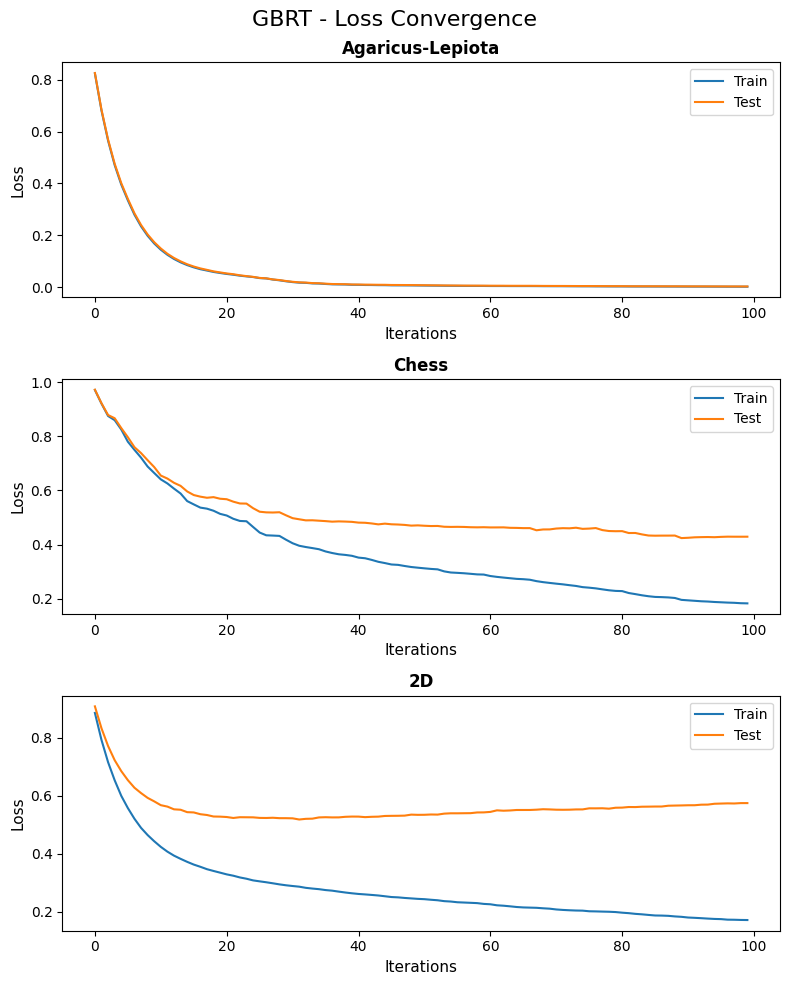

In [15]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("GBRT - Loss Convergence", size=16)
for i, (name, result) in enumerate(gbrt_results.items()):
    dataset = {"Train": result['Train'][0], "Test": result['Test'][0]}
    plot_results(axes[i], dataset, "Iterations", "Loss", f"{name}")
plt.tight_layout();

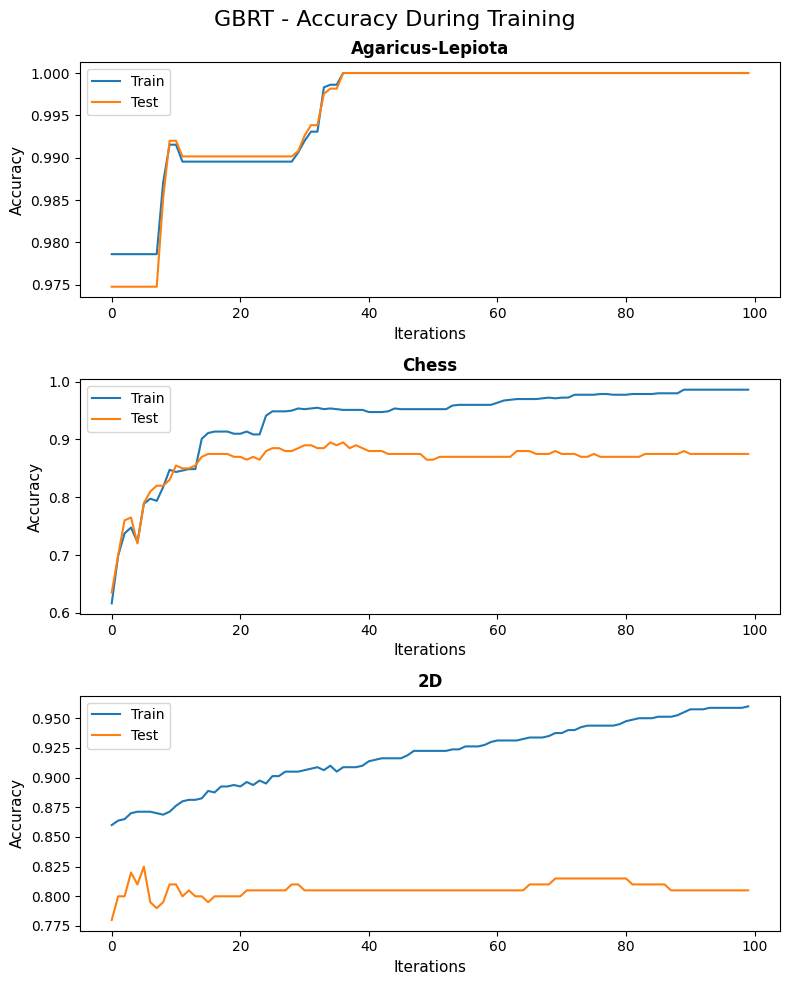

In [16]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("GBRT - Accuracy During Training", size=16)
for i, (name, model) in enumerate(models.items()):
    dataset = {"Train": 1 - model.train_errors, "Test": 1 - model.test_errors}
    plot_results(axes[i], dataset, "Iterations", "Accuracy", f"{name}")
plt.tight_layout();

#### Running GBRT on Agaricus-Lepiota dataset after dimensionality reduction

In [17]:
gbrt_model = GBRT(n_trees=100)
gbrt_train_loss, gbrt_test_loss = gbrt_model.fit(AgaricusL_db.X_train_reduced, y_train1, AgaricusL_db.X_test_reduced, y_test1)
train_pred = gbrt_model.predict(AgaricusL_db.X_train_reduced)
test_pred = gbrt_model.predict(AgaricusL_db.X_test_reduced)
gbrt_test_accuracy = gbrt_model.calc_accuracy(AgaricusL_db.y_test, test_pred)
gbrt_train_accuracy = gbrt_model.calc_accuracy(AgaricusL_db.y_train, train_pred)
print(f'Agaricus-Lepiota Train Accuracy after dimension reduction: {gbrt_train_accuracy: 0.2f}')
print(f'Agaricus-Lepiota Test Accuracy after dimension reduction: {gbrt_test_accuracy: 0.2f}')

Agaricus-Lepiota Train Accuracy after dimension reduction:  99.25
Agaricus-Lepiota Test Accuracy after dimension reduction:  97.91


In [18]:
def plot_decision_boundaries(ax, X, y, clf, feature_names, dataset_name, resolution=0.1):
    # Plot the decision surface
    axis_max = abs(X).max().round() +1
    
    xx1, xx2 = np.meshgrid(np.arange(-axis_max, axis_max, resolution),
                           np.arange(-axis_max, axis_max, resolution))
    
    # axis_max = X.max().round()
    # axis_min = X.min().round() 
    
    # xx1, xx2 = np.meshgrid(np.arange(axis_min, axis_max, resolution),
    #                        np.arange(axis_min, axis_max, resolution))
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    
    ax.contourf(xx1, xx2, Z, alpha=0.4)
    
    # Plot class sample
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k')
    
    ax.set_xlim(-axis_max, axis_max)
    ax.set_ylim(-axis_max, axis_max)
        
    # ax.set_xlim(axis_min, axis_max)
    # ax.set_ylim(axis_min, axis_max)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(dataset_name, size=16, fontweight="bold")

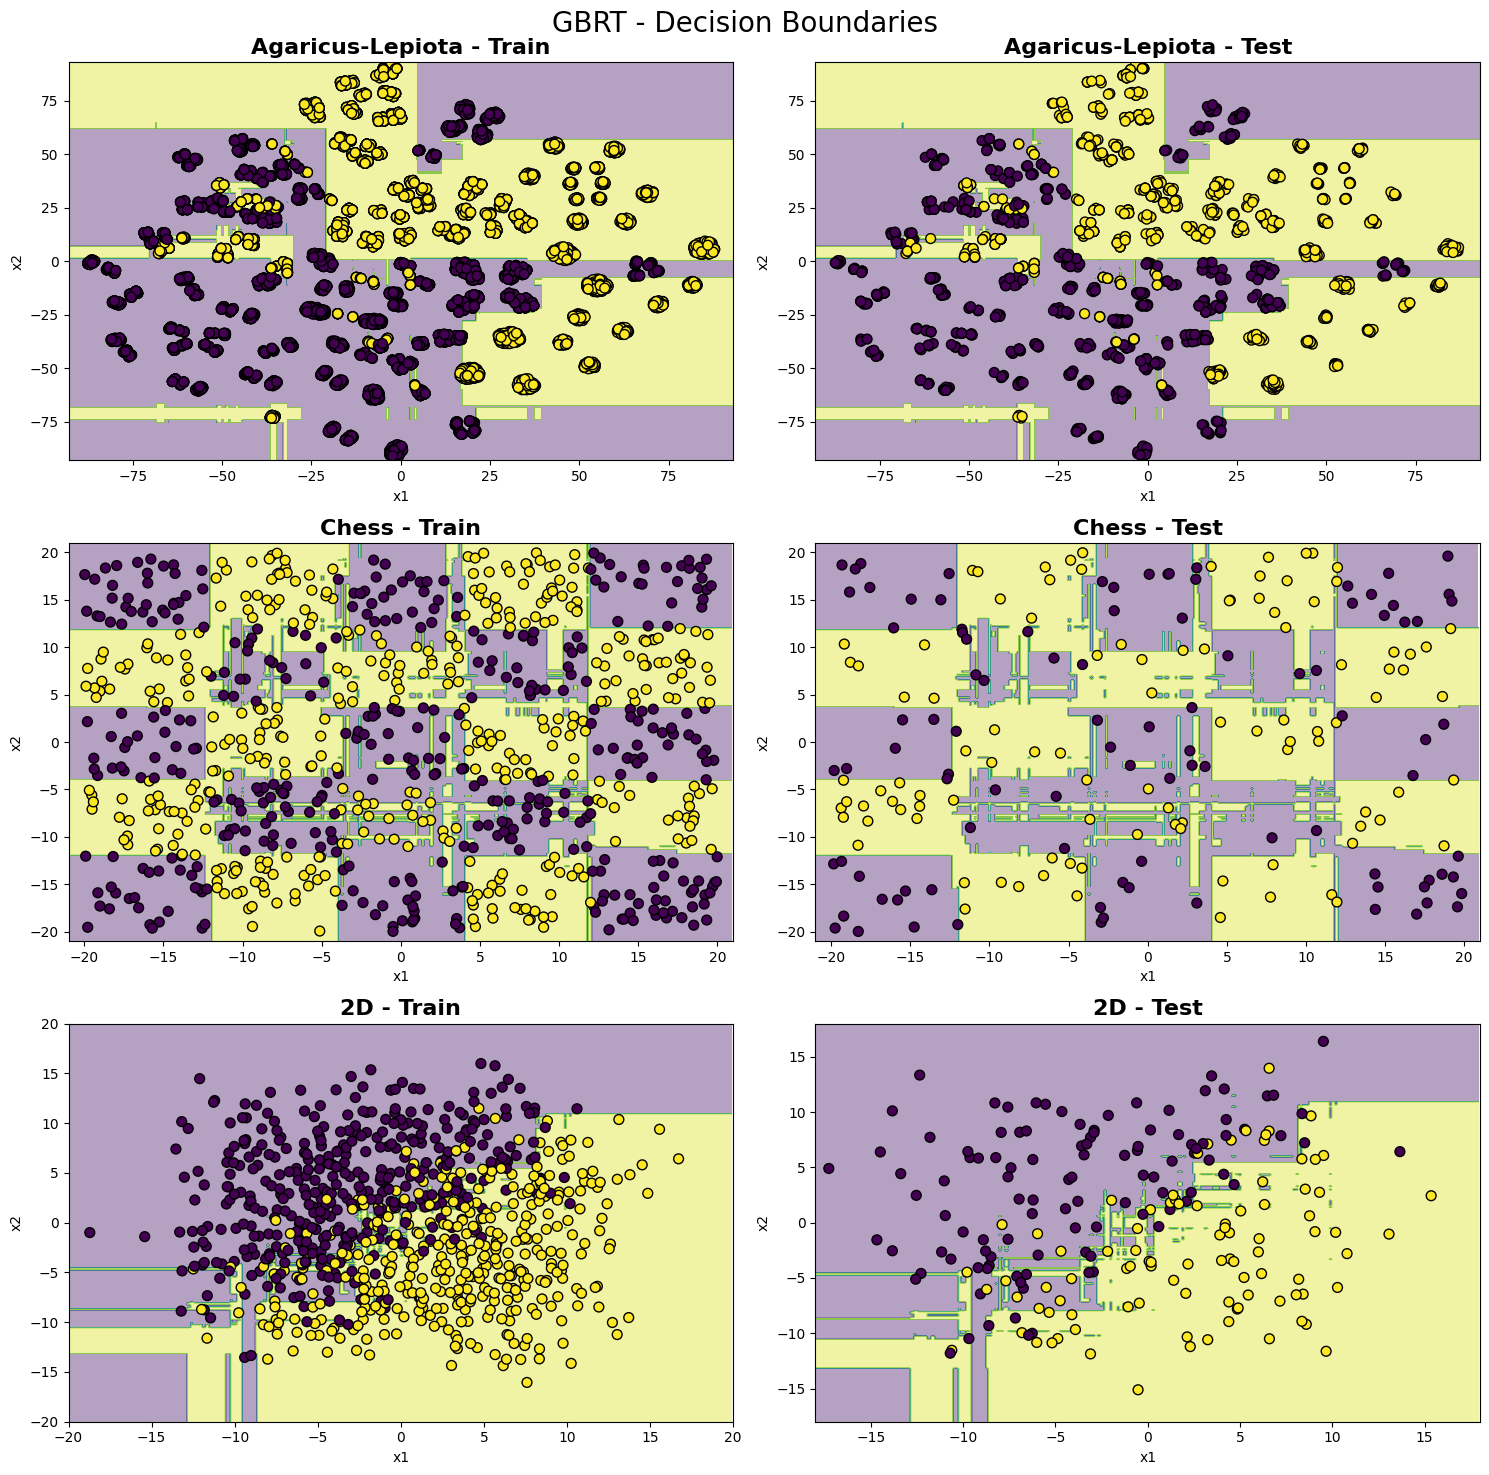

In [19]:
fig, axes = plt.subplots(len(datasets), 2, figsize=(15,15))
for i in range(1,len(datasets)):
    plot_decision_boundaries(axes[i,0],datasets[i].X_train, datasets[i].y_train, models[datasets[i].name], ['x1','x2'], f"{datasets[i].name} - Train")
    plot_decision_boundaries(axes[i,1],datasets[i].X_test, datasets[i].y_test, models[datasets[i].name], ['x1','x2'], f"{datasets[i].name} - Test")
plot_decision_boundaries(axes[0,0],AgaricusL_db.X_train_reduced, AgaricusL_db.y_train, gbrt_model, ['x1','x2'], f"{AgaricusL_db.name} - Train")
plot_decision_boundaries(axes[0,1],AgaricusL_db.X_test_reduced, AgaricusL_db.y_test, gbrt_model, ['x1','x2'], f"{AgaricusL_db.name} - Test")
plt.suptitle("GBRT - Decision Boundaries", size=20)
plt.subplots_adjust(top=0.85)
plt.tight_layout()

### GBRT - Experiments

#### Experiment 1 - Accuracy as a function of Max depth

In [20]:
def accuracy_test(model1, dataset, params, experiment_param: str, args: dict):
    train_accuracies  = []
    test_accuracies  = []
    for param in params:
        args[experiment_param] = param
        model = model1(**args)
        model.fit(dataset.X_train,dataset.y_train, dataset.X_test, dataset.y_test)
        train_pred = model.predict(dataset.X_train)
        test_pred = model.predict(dataset.X_test)
        test_accuracy = model.calc_accuracy(dataset.y_test, test_pred)
        train_accuracy = model.calc_accuracy(dataset.y_train, train_pred)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        args.pop(experiment_param)
    return train_accuracies, test_accuracies

In [21]:
results = defaultdict(dict)
for dataset in datasets:
    results[dataset.name]["Train"], results[dataset.name]["Test"] = accuracy_test(GBRT, dataset, np.arange(1,15), "max_depth", {"n_trees":100})

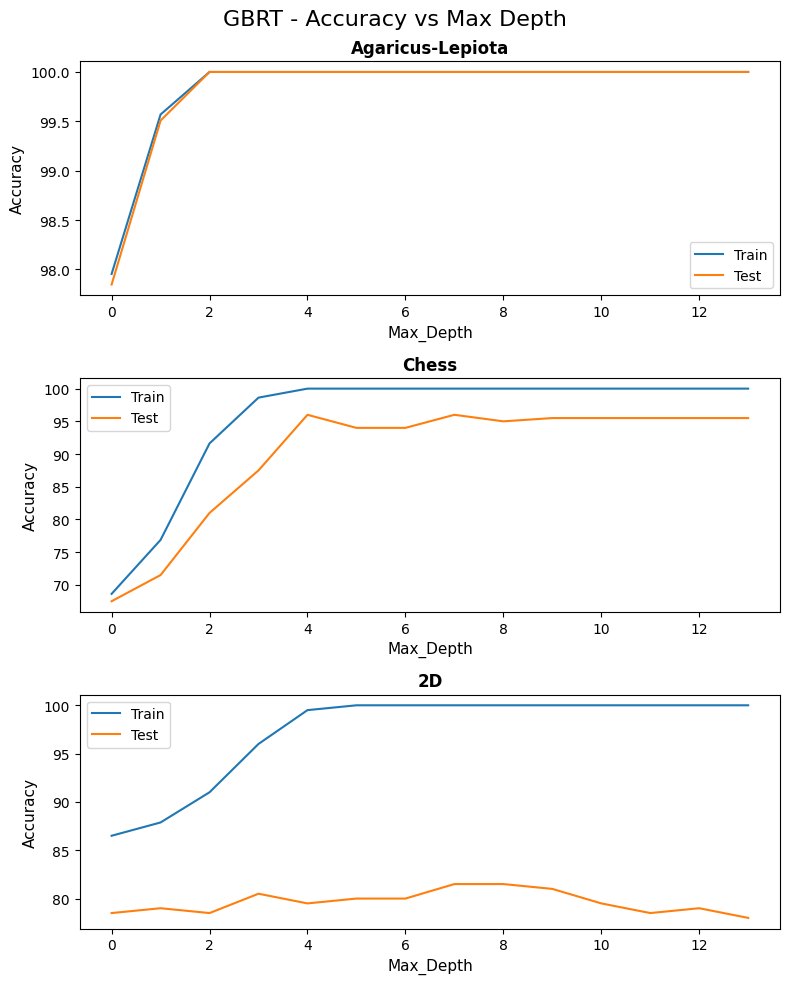

In [22]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("GBRT - Accuracy vs Max Depth", size=16)
for i, (name, result) in enumerate(results.items()):
    dataset = {"Train": result['Train'], "Test": result['Test']}
    plot_results(axes[i], dataset, "Max_Depth", "Accuracy", f"{name}")
plt.tight_layout();

#### Experiment 2 - Accuracy as a function of n_trees

In [23]:
results = defaultdict(dict)
for dataset in datasets:
    results[dataset.name]["Train"], results[dataset.name]["Test"] = accuracy_test(GBRT, dataset, np.arange(1,100), "n_trees", {"max_depth":3})

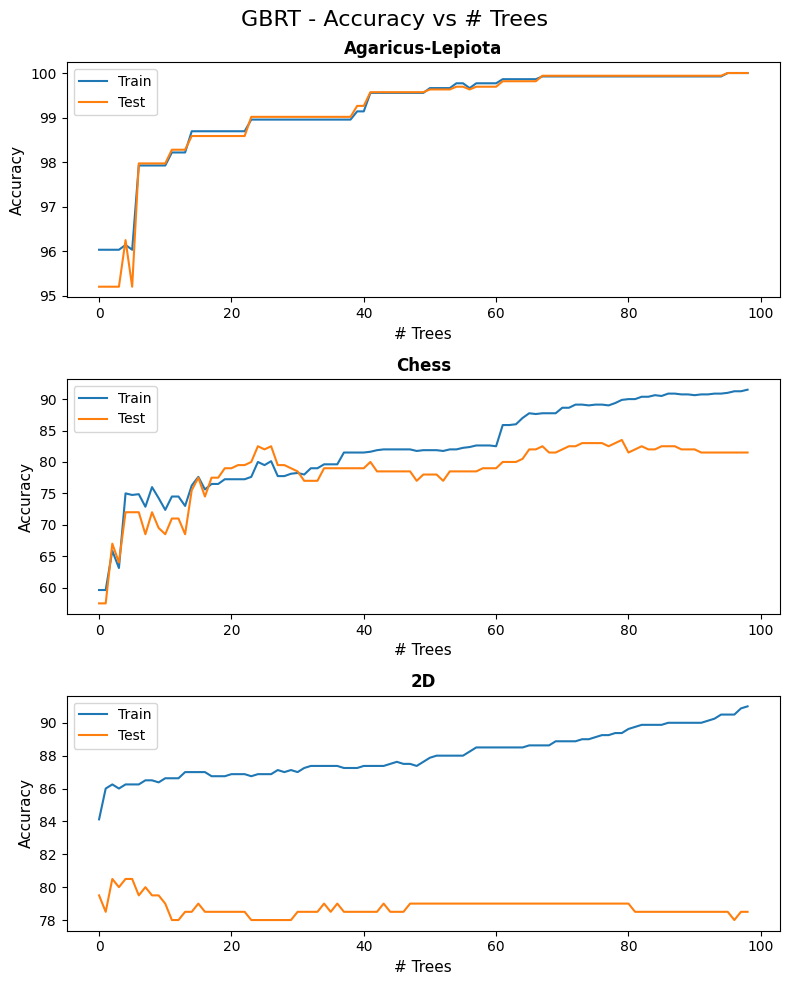

In [24]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("GBRT - Accuracy vs # Trees", size=16)
for i, (name, result) in enumerate(results.items()):
    dataset = {"Train": result['Train'], "Test": result['Test']}
    plot_results(axes[i], dataset, "# Trees", "Accuracy", f"{name}")
plt.tight_layout();

#### Experiment 3 - Convergence as a function of Alpha

In [25]:
def run_alpha_exp(dataset):
    alphas = [0.001, 0.01, 0.1, 0.5]
    losses = {}
    accuracy_result = pd.DataFrame()
    for alpha in alphas:
        model = GBRT(alpha=alpha ,n_trees=100)
        loss , _ = model.fit(dataset.X_train, dataset.y_train ,dataset.X_test, dataset.y_test)
        train_pred = model.predict(dataset.X_train)
        train_accuracy = model.calc_accuracy(dataset.y_train, train_pred)
        losses[alpha] = loss
        pred = model.predict(dataset.X_test)
        test_accuracy = model.calc_accuracy(dataset.y_test, pred)
        accuracy_result = pd.concat([accuracy_result, pd.DataFrame({'Alpha': [alpha, alpha], 'Data': ['Train', 'Test'], 'Accuracy': [train_accuracy, test_accuracy]})])
    return accuracy_result, losses


In [26]:
results = defaultdict(dict)
for dataset in datasets:
    results[dataset.name]["Accuracy"], results[dataset.name]["Loss"] = run_alpha_exp(dataset)

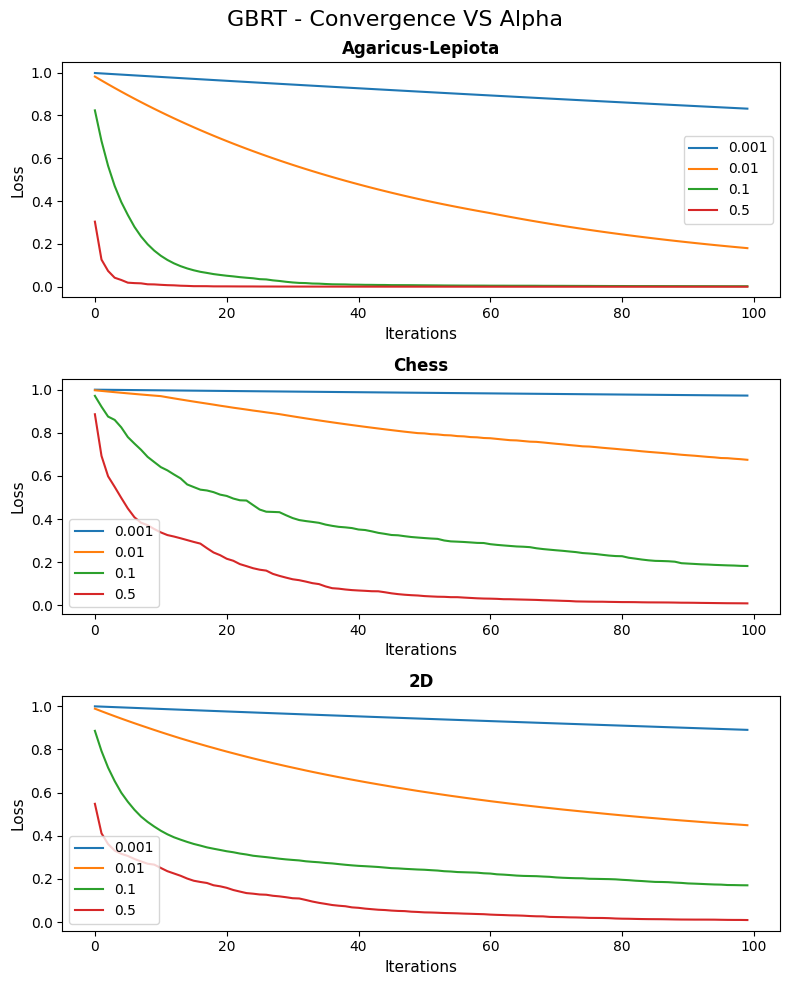

In [27]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("GBRT - Convergence VS Alpha", size=16)
for i, (name, result) in enumerate(results.items()):
    plot_results(axes[i], result["Loss"], "Iterations", "Loss", f"{name}")
plt.tight_layout();

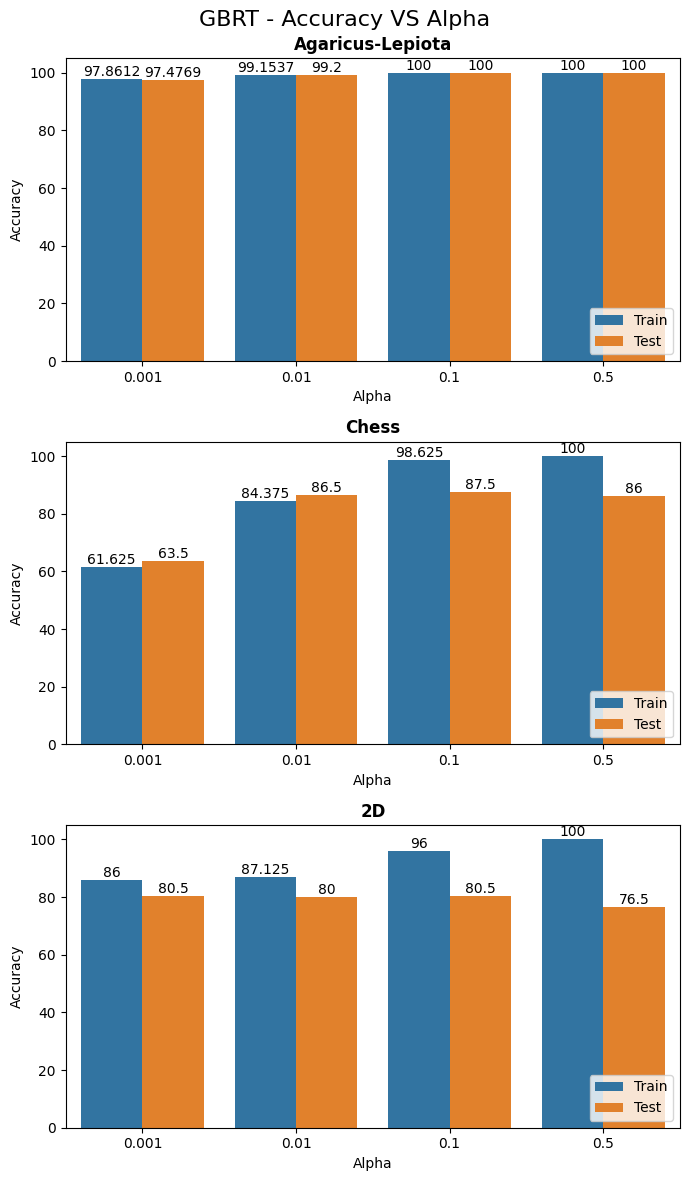

In [28]:

fig, axes = plt.subplots(3,1,figsize = (7, 12))
plt.suptitle("GBRT - Accuracy VS Alpha", size=16)
for i, (name, result) in enumerate(results.items()):
    sns.barplot(x='Alpha', y='Accuracy', hue='Data',  data=result["Accuracy"], ax=axes[i])
    axes[i].set_title(name, size=12, fontweight="bold")
    for j in axes[i].containers:
        axes[i].bar_label(j,)
    axes[i].legend(loc='lower right')
plt.tight_layout();



## Part 2:  AdaBoost

In [29]:
class AdaBoost:
    def __init__(self, n_trees: int = 100) -> None:
        self.n_trees = n_trees
        self.trees = []
        self.alphas = np.zeros(n_trees)
        self.train_errors = []
        self.test_errors = []

    def calc_loss(self, y: np.array, y_pred: np.array):
        return np.exp(-y*y_pred).mean()
    
    def fit(self, X: np.array, y: np.array,  X_test: np.array = None, y_test: np.array = None) -> list:
        loss_history = []
        test_history = []
        weights = np.full(y.shape, 1/y.shape[0])
        pred = np.zeros(y.shape)
        if y_test is not None:
            pred_test = np.zeros(y_test.shape)
        for i in range(self.n_trees):
            loss_history.append(self.calc_loss(y,pred))
            train_error = (y != np.where(pred>=0, 1, -1))
            self.train_errors.append(train_error.mean())
            tree = DecisionTreeClassifier(max_depth=1)
            tree.fit(X, y, sample_weight=weights)
            y_pred = tree.predict(X)
            total_error = weights[y != y_pred].sum()
            if total_error == 0 or total_error > 0.5:
                break
            alpha = 0.5 * np.log((1-total_error) / total_error)
            self.alphas[i] = alpha
            weights = weights * np.exp(-alpha *(y_pred * y)) 
            weights = weights / weights.sum()
            pred += alpha * y_pred
            self.trees.append(tree)
            if X_test is not None:
                test_history.append(self.calc_loss(y_test,pred_test))
                test_error = (y_test != np.where(pred_test>=0, 1, -1))
                self.test_errors.append(test_error.mean())
                y_test_pred = tree.predict(X_test)
                pred_test += alpha * y_test_pred
                

        return loss_history, test_history
    
    def predict(self, X) -> np.array:
         predictions = np.array(list(map(lambda x: x.predict(X), self.trees)))
         y_pred = self.alphas @ predictions
         return np.where(y_pred>=0, 1, -1)

    def calc_accuracy(self, y, y_pred):
        return 100 * accuracy_score(y, y_pred)   
        

### AdaBoost - Results

In [30]:
from collections import defaultdict
ada_results = defaultdict(lambda: defaultdict(tuple))
models = {}
for dataset in datasets:
    ada_model = AdaBoost(n_trees=100)
    ada_train_loss, ada_test_loss = ada_model.fit(dataset.X_train, dataset.y_train, dataset.X_test, dataset.y_test)
    train_pred = ada_model.predict(dataset.X_train)
    test_pred = ada_model.predict(dataset.X_test)
    ada_test_accuracy = ada_model.calc_accuracy(dataset.y_test, test_pred)
    ada_train_accuracy = ada_model.calc_accuracy(dataset.y_train, train_pred)
    models[dataset.name] = ada_model
    ada_results[dataset.name]["Train"]= (ada_train_loss ,ada_train_accuracy)
    ada_results[dataset.name]["Test"] = (ada_test_loss, ada_test_accuracy)


In [31]:
for name, result in ada_results.items():
    print(f"{name} Train Accuracy: {result['Train'][1]: 0.2f}")
    print(f"{name} Test Accuracy: {result['Test'][1]:0.2f}")

Agaricus-Lepiota Train Accuracy:  99.97
Agaricus-Lepiota Test Accuracy: 100.00
Chess Train Accuracy:  70.12
Chess Test Accuracy: 69.50
2D Train Accuracy:  85.12
2D Test Accuracy: 81.50


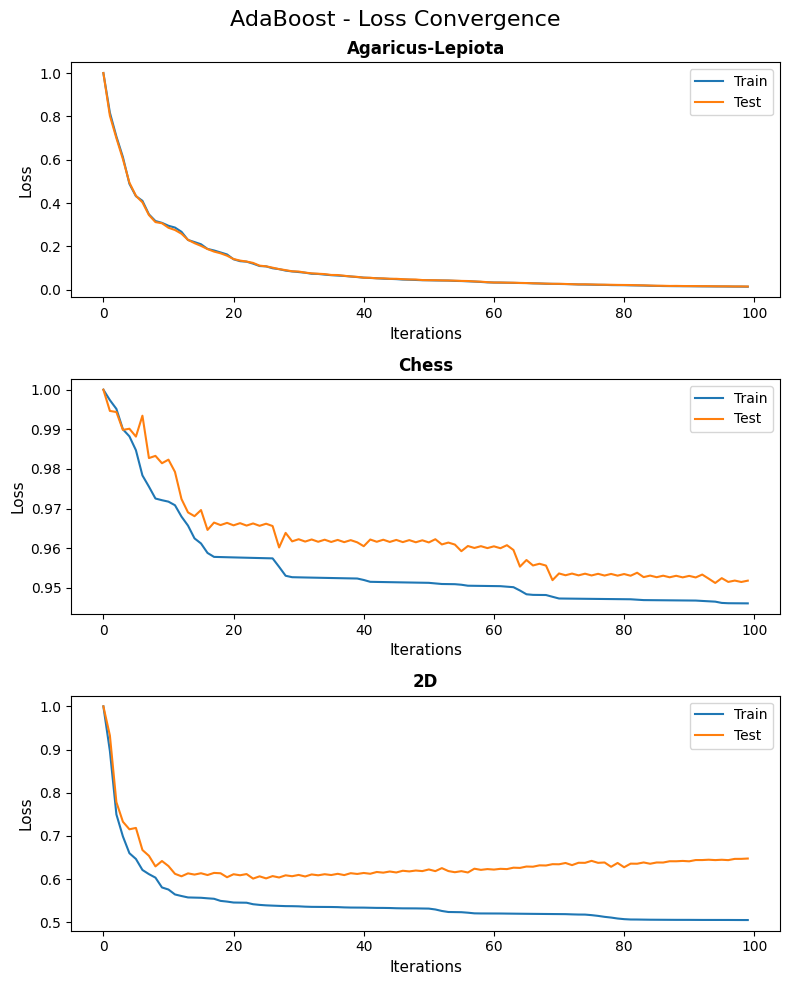

In [32]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("AdaBoost - Loss Convergence", size=16)
for i, (name, result) in enumerate(ada_results.items()):
    dataset = {"Train": result['Train'][0], "Test": result['Test'][0]}
    plot_results(axes[i], dataset, "Iterations", "Loss", f"{name}")
plt.tight_layout();

#### Running AdaBoost on Agaricus-Lepiota dataset after dimensionality reduction

In [33]:
ada_model = AdaBoost(n_trees=100)
ada_train_loss, ada_test_loss = ada_model.fit(AgaricusL_db.X_train_reduced, y_train1, AgaricusL_db.X_test_reduced, y_test1)
train_pred = ada_model.predict(AgaricusL_db.X_train_reduced)
test_pred = ada_model.predict(AgaricusL_db.X_test_reduced)
ada_test_accuracy = ada_model.calc_accuracy(AgaricusL_db.y_test, test_pred)
ada_train_accuracy = ada_model.calc_accuracy(AgaricusL_db.y_train, train_pred)
print(f'Agaricus-Lepiota Train Accuracy after dimension reduction: {ada_train_accuracy: 0.2f}')
print(f'Agaricus-Lepiota Test Accuracy after dimension reduction: {ada_test_accuracy: 0.2f}')

Agaricus-Lepiota Train Accuracy after dimension reduction:  84.67
Agaricus-Lepiota Test Accuracy after dimension reduction:  85.29


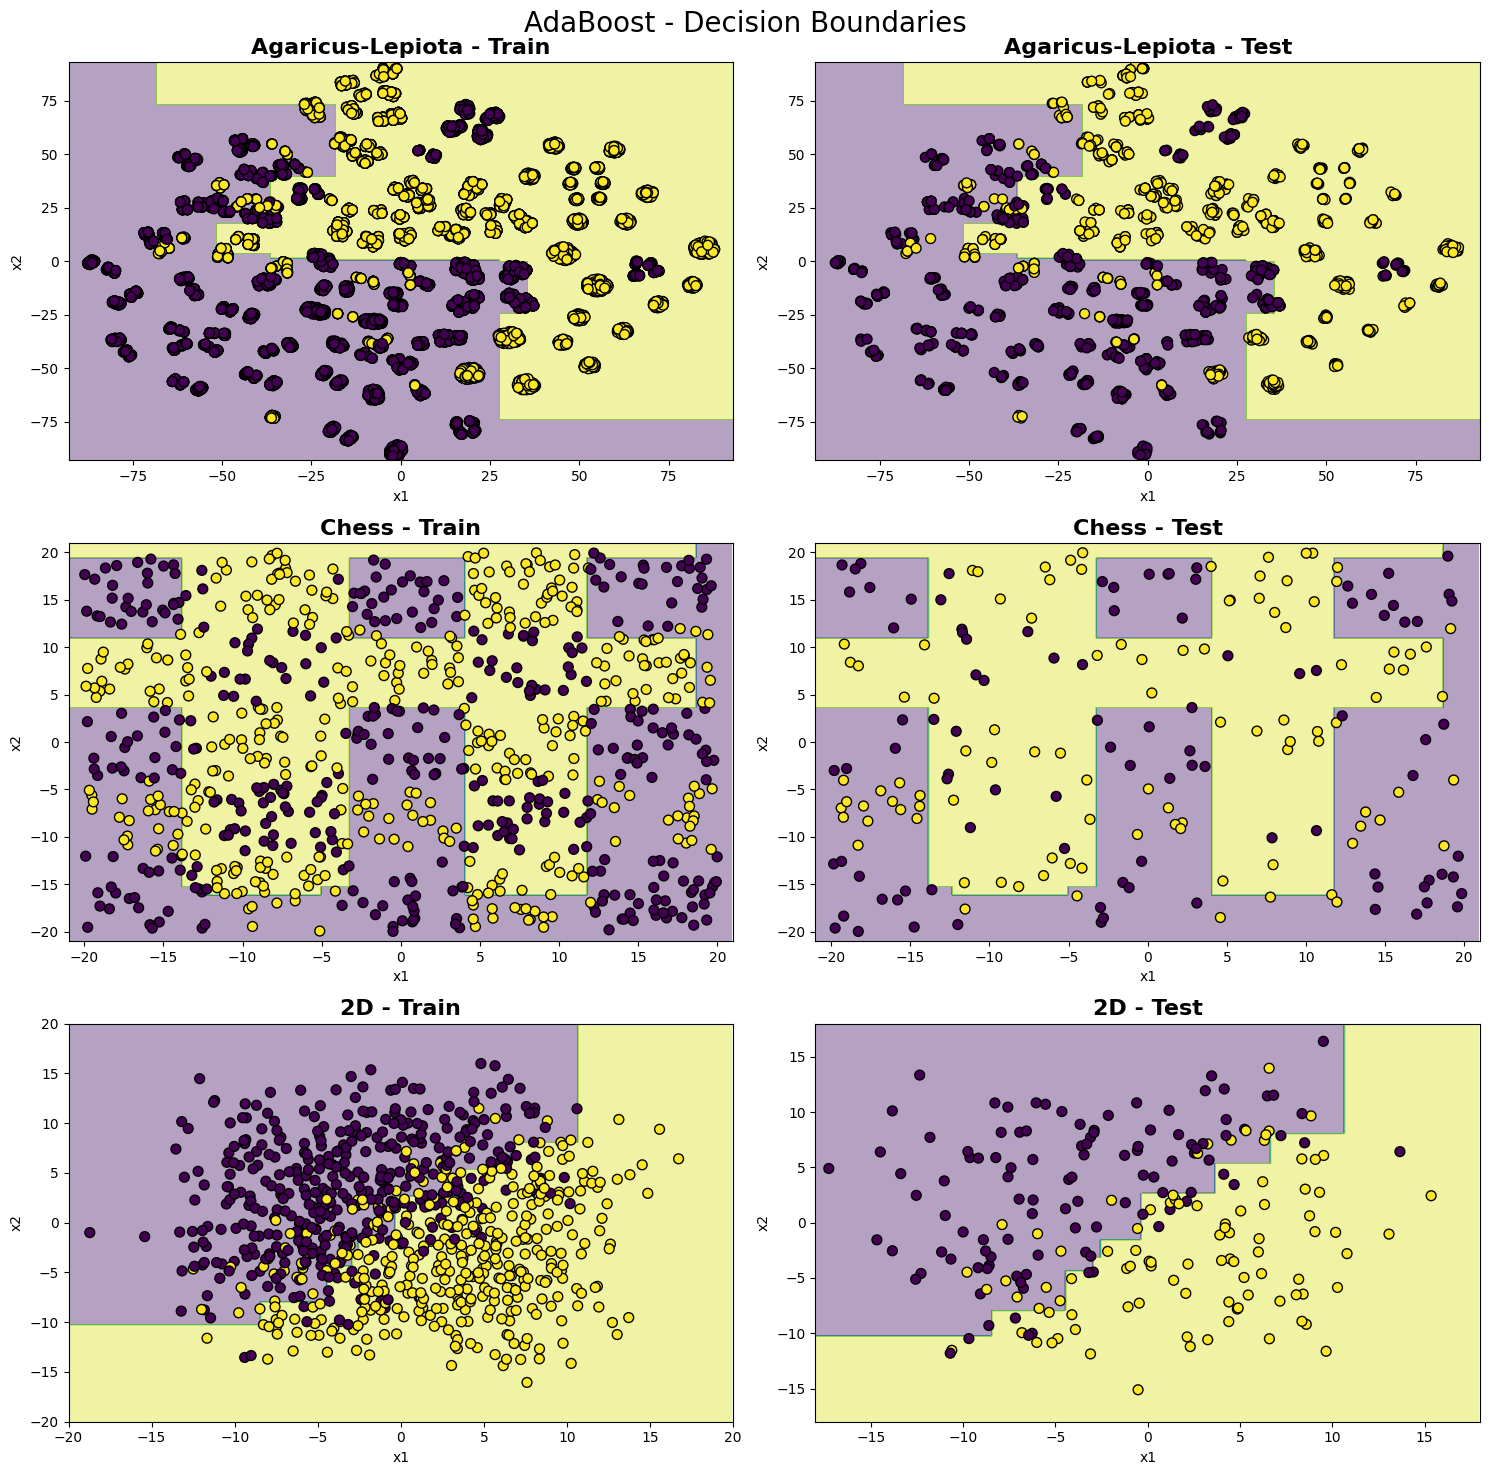

In [34]:
fig, axes = plt.subplots(len(datasets), 2, figsize=(15,15))
for i in range(1,len(datasets)):
    plot_decision_boundaries(axes[i,0],datasets[i].X_train, datasets[i].y_train, models[datasets[i].name], ['x1','x2'], f"{datasets[i].name} - Train")
    plot_decision_boundaries(axes[i,1],datasets[i].X_test, datasets[i].y_test, models[datasets[i].name], ['x1','x2'], f"{datasets[i].name} - Test")
plot_decision_boundaries(axes[0,0],AgaricusL_db.X_train_reduced, AgaricusL_db.y_train, ada_model, ['x1','x2'], f"{AgaricusL_db.name} - Train")
plot_decision_boundaries(axes[0,1],AgaricusL_db.X_test_reduced, AgaricusL_db.y_test, ada_model, ['x1','x2'], f"{AgaricusL_db.name} - Test")
plt.suptitle("AdaBoost - Decision Boundaries", size=20)
plt.subplots_adjust(top=0.85)
plt.tight_layout()

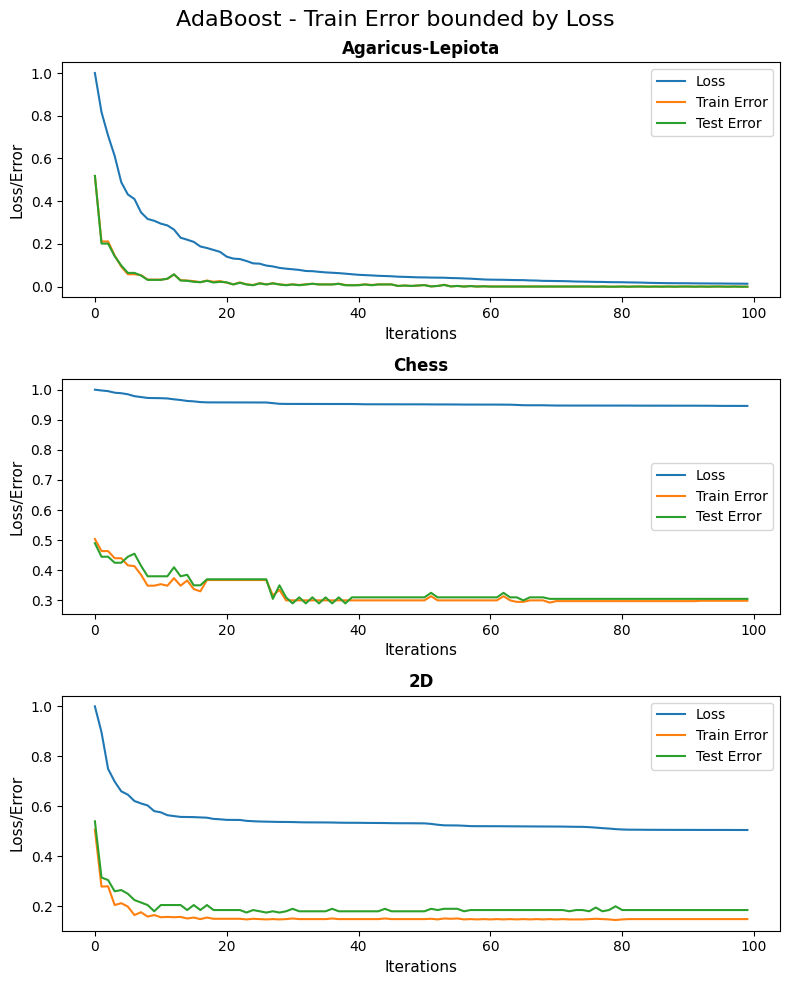

In [35]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("AdaBoost - Train Error bounded by Loss", size=16)
for i, (name, model) in enumerate(models.items()):
    dataset = {"Loss": ada_results[name]["Train"][0], "Train Error": model.train_errors, "Test Error": model.test_errors}
    plot_results(axes[i], dataset, "Iterations", "Loss/Error", f"{name}")
plt.tight_layout();

### AdaBoost - Experiments

#### Experiment 1 - Accuracy as a function of number of trees

In [36]:
results = defaultdict(dict)
for dataset in datasets:
    results[dataset.name]["Train"], results[dataset.name]["Test"] = accuracy_test(AdaBoost, dataset, np.arange(1,101), "n_trees", {})

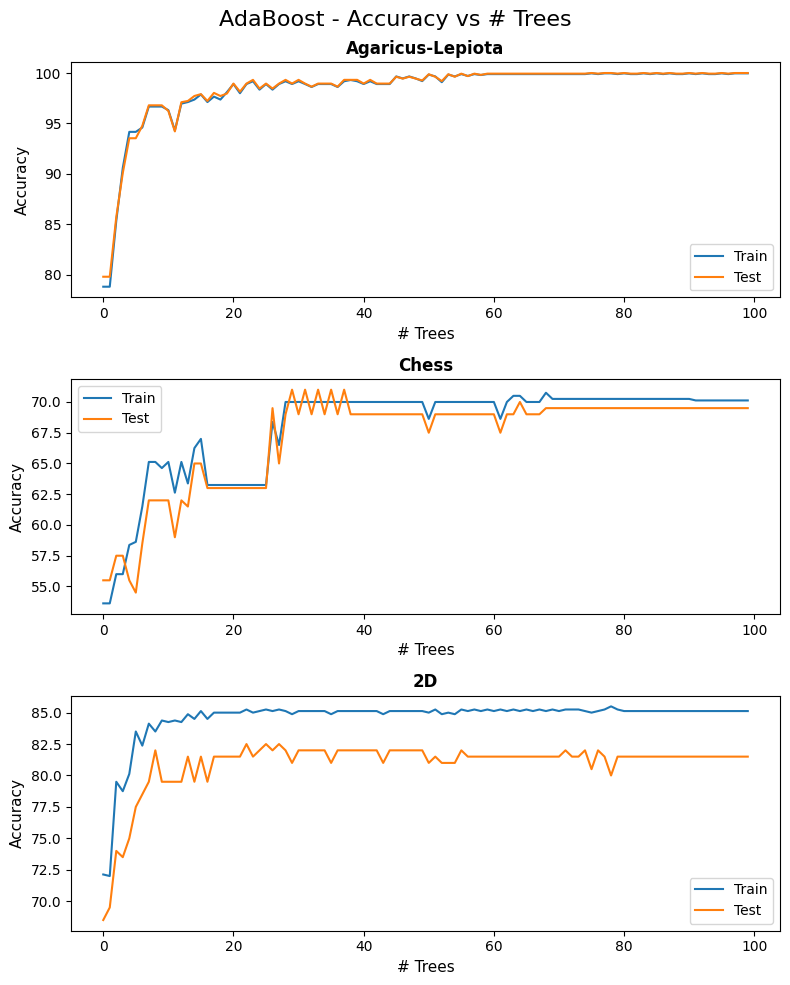

In [37]:
fig, axes = plt.subplots(3,1,figsize = (8, 10))
plt.suptitle("AdaBoost - Accuracy vs # Trees", size=16)
for i, (name, result) in enumerate(results.items()):
    dataset = {"Train": result['Train'], "Test": result['Test']}
    plot_results(axes[i], dataset, "# Trees", "Accuracy", f"{name}")
plt.tight_layout();

#### Experiment 2 - AdaBoost VS GBRT

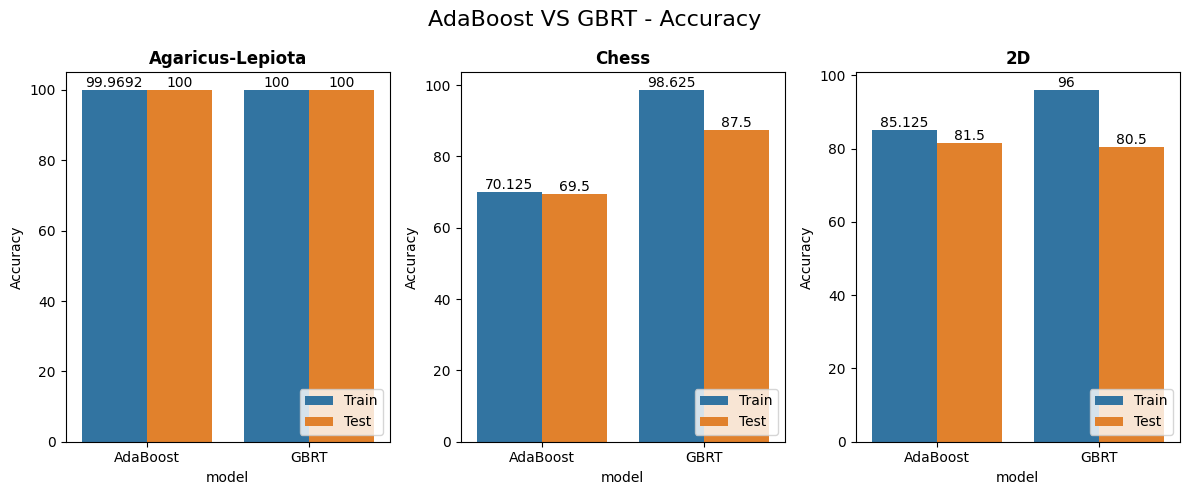

In [38]:
fig, axes = plt.subplots(1,3,figsize = (12, 5))
plt.suptitle("AdaBoost VS GBRT - Accuracy", size=16)
for i, dataset in enumerate(datasets):
    results = pd.DataFrame({'model': ["AdaBoost", "AdaBoost"], 'Data': ['Train', 'Test'], 'Accuracy':
                             [ada_results[dataset.name]["Train"][1], ada_results[dataset.name]["Test"][1]]})
    results = pd.concat([results, pd.DataFrame({'model': ["GBRT", "GBRT"], 'Data': ['Train', 'Test'], 'Accuracy': 
                                               [gbrt_results[dataset.name]["Train"][1], gbrt_results[dataset.name]["Test"][1]]})])
    sns.barplot(x='model', y='Accuracy', hue='Data',  data=results, ax=axes[i])
    axes[i].set_title(dataset.name, size=12, fontweight="bold")
    for j in axes[i].containers:
        axes[i].bar_label(j,)
    axes[i].legend(loc='lower right')
plt.tight_layout();
    


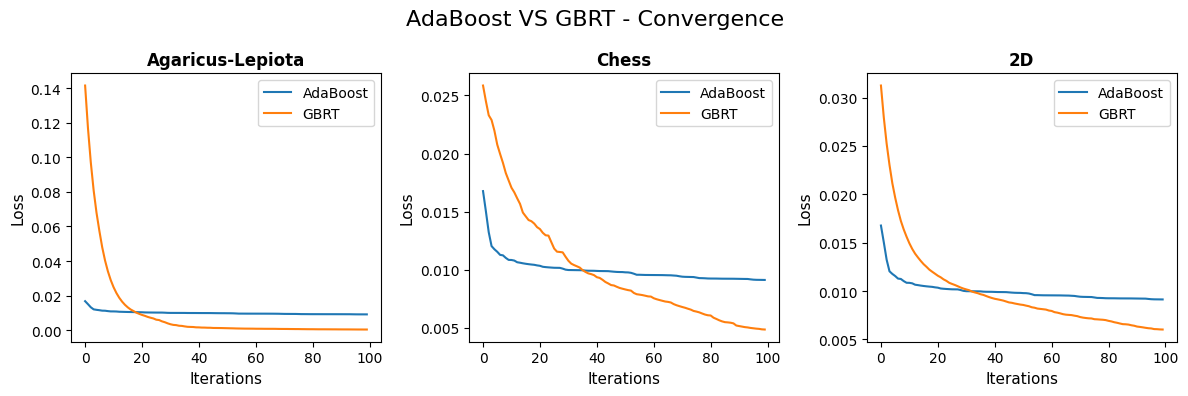

In [39]:
fig, axes = plt.subplots(1,3,figsize = (12, 4))
plt.suptitle("AdaBoost VS GBRT - Convergence", size=16)
for i, dataset in enumerate(datasets):
    ada_loss = np.array(ada_results[dataset.name]["Train"][0])
    ada_loss = np.array(ada_train_loss)
    ada_loss /= ada_loss.sum()
    gbrt_loss = np.array(gbrt_results[dataset.name]["Train"][0])
    gbrt_loss /= gbrt_loss.sum()
    results = {"AdaBoost": ada_loss, "GBRT": gbrt_loss}
    plot_results(axes[i], results, "Iterations", "Loss", dataset.name)
plt.tight_layout();